## ATAC + MULTIOME (females) - september 2021

### Build anndata from cellatac output 

In [73]:
# Load libraries
import pandas as pd 
import scanpy as sc
import numpy as np
import scipy.sparse

In [74]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/females_july2021/"
experiment_prefix = 'females_'
cellatac_outdir = '/warehouse/cellgeni/tic-1127/results200k/'


In [75]:
input={'cnts': cellatac_outdir + 'peak_matrix/peaks_bc_matrix.mmtx.gz',
        "bcs": cellatac_outdir + 'peak_matrix/bc.txt',
      "peaks": cellatac_outdir + 'peak_matrix/peaks.txt',
      'clusters': cellatac_outdir + 'qc/seurat-clades.tsv'}

output = {
    "cnt_mmtx":outdir + experiment_prefix + '_ATAC_cisTopic.mmtx',
    "cnt_peaks":outdir + experiment_prefix + '_ATAC_cisTopic.peaks.tsv',
    "cnt_cells":outdir + experiment_prefix + '_ATAC_cisTopic.cells.tsv',
    "h5ad":outdir + experiment_prefix + '_ATAC_raw.h5ad',
}

#### Make anndata object

In [76]:
adata = sc.read_mtx(input["cnts"]).T

bc = pd.read_table(input["bcs"], header=None)
feat = pd.read_table(input["peaks"], header=None)

adata.obs_names = bc[0]
adata.var_names = feat[0]

In [77]:
adata

AnnData object with n_obs × n_vars = 93860 × 534188

In [78]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

08    12913
01    12651
07     8901
03     8668
09     8394
11     5326
17     5112
12     4974
02     4882
06     4878
05     3458
13     3164
14     3136
16     2472
10     2114
15     1645
04     1172
Name: code, dtype: int64

In [79]:
# Sample from code 
sample_dictionary = {'01' : 'HCA_F_GON10535399', '02' : 'HCA_F_GON10687818', '03' : 'FCA_GND8046539', 
                    '04' : 'FCA_GND8768483', '05' : 'FCA_GND8768484', '06' : 'FCA_GND8768485', 
                     '07' : 'HD_F_GON9479873', '08' : 'HD_F_GON9479874', '09' : 'HD_F_GON9479875', 
                     '10' : 'HD_F_GON9525613', '11' : 'HD_F_GON9883959', '12' : 'HD_F_GON9883960', 
                    '13' : 'FCA_GND10288176', '14' : 'FCA_GND10288177', '15' : 'FCA_GND10288178', 
                    '16' : 'FCA_GND10288179', '17' : 'FCA_GND10288180'}
adata.obs['sample'] = adata.obs['code'].map(sample_dictionary) 
adata.obs['sample'].value_counts(dropna = False)

HD_F_GON9479874      12913
HCA_F_GON10535399    12651
HD_F_GON9479873       8901
FCA_GND8046539        8668
HD_F_GON9479875       8394
HD_F_GON9883959       5326
FCA_GND10288180       5112
HD_F_GON9883960       4974
HCA_F_GON10687818     4882
FCA_GND8768485        4878
FCA_GND8768484        3458
FCA_GND10288176       3164
FCA_GND10288177       3136
FCA_GND10288179       2472
HD_F_GON9525613       2114
FCA_GND10288178       1645
FCA_GND8768483        1172
Name: sample, dtype: int64

In [80]:
## Remove sample HD_F_GON9525613 which is extragonadal 
adata = adata[[i not in ['HD_F_GON9525613'] for i in adata.obs['sample']]]
adata.shape

(91746, 534188)

#### Load peak annotations (done with R script by Emma)

In [81]:
peak_anno_df = pd.read_csv(outdir + "ATACpeaks_annotation.csv", index_col=0)
peak_anno_df.index = peak_anno_df["peak_id"]
peak_anno_df.drop("peak_id",1, inplace=True)
adata.var = pd.concat([adata.var, peak_anno_df], 1)

#### Save binary data to layers

In [82]:
adata.layers["binary_raw"] = adata.X
adata.layers["binary_raw"][adata.layers["binary_raw"] > 1] = 1
adata

AnnData object with n_obs × n_vars = 91746 × 534188
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist'
    layers: 'binary_raw'

#### Load annotations of snRNAseq from MULTIOME samples 

1. Germ cells 

In [83]:
path_to_multiome = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [84]:
germcells = pd.read_csv(path_to_multiome + 'multiomics_female_germcells.csv')
germcells.head()

,Unnamed: 0,n_genes,sample,donor,Library_ATAC,Library_RNA,iRods_path,percent_mito,n_counts,batch,...,bonf_pval,pcw,lineage,celltype_samplespecific,S_score,G2M_score,phase,leiden,leiden_R,celltype
0,HCA_F_GON10535495_AAACCAACACGAATTT,5728,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.014532,4735.2485,0,...,1.0,8.6,GermCells,NaN,0.237842,0.087936,S,0,0,PGC
1,HCA_F_GON10535495_AACCCGCAGTTTGAGC,5456,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.017976,4645.2330,0,...,1.0,8.6,GermCells,NaN,0.037234,-0.421033,S,0,0,PGC
2,HCA_F_GON10535495_AACGACAAGCGGCTGT,5901,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.018170,4060.9746,0,...,1.0,8.6,GermCells,NaN,0.114108,4.491824,G2M,0,0,PGC
3,HCA_F_GON10535495_AACTTAGTCTTGTCCA,6781,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.020457,4499.4067,0,...,1.0,8.6,GermCells,NaN,0.002280,6.158810,G2M,0,0,PGC
4,HCA_F_GON10535495_AAGACCAAGCACCACA,4881,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.015051,4630.9404,0,...,1.0,8.6,GermCells,NaN,-0.099797,-0.189805,G1,0,0,PGC


**!!! Library_ATAC has wrong codes, replace them with correct ones**

In [85]:
germcells['Library_RNA'].value_counts()

FCA_GND10287604      1171
HCA_F_GON10713284    1091
FCA_GND10287600       942
FCA_GND10287601       923
FCA_GND10287603       781
FCA_GND10287602       533
HCA_F_GON10535495     252
Name: Library_RNA, dtype: int64

In [86]:
libraries_correspondence = {'FCA_GND10287600' : 'FCA_GND10288176', 'FCA_GND10287601' : 'FCA_GND10288177', 
                           'FCA_GND10287602' : 'FCA_GND10288178', 'FCA_GND10287603' : 'FCA_GND10288179', 
                           'FCA_GND10287604' : 'FCA_GND10288180', 'HCA_F_GON10535495' : 'HCA_F_GON10535399',
                           'HCA_F_GON10713284' : 'HCA_F_GON10687818'}

In [87]:
germcells['ATAC_correct'] = germcells['Library_RNA'].map(libraries_correspondence)

In [88]:
code_correspondence = {'FCA_GND10288180' : '17', 'FCA_GND10288176' : '13', 'FCA_GND10288177' : '14',
                      'FCA_GND10288179' : '16', 'FCA_GND10288178' : '15', 'HCA_F_GON10535399' : '01',
                      'HCA_F_GON10687818' : '02'}

In [89]:
germcells['ATAC_code'] = germcells['ATAC_correct'].map(code_correspondence)

In [90]:
germcells['ATAC_code'].value_counts(dropna = False)

17    1171
02    1091
13     942
14     923
16     781
15     533
01     252
Name: ATAC_code, dtype: int64

In [91]:
germcells['barcode'] = [i.split('_')[-1] for i in germcells['Unnamed: 0']]

In [92]:
germcells['ATAC_barcode'] = germcells['ATAC_code'] + '-' + germcells['barcode'] + '-1'

2. Somatic cells 

In [93]:
supporting = pd.read_csv(path_to_multiome + 'multiomics_female_somatic.csv')
supporting.head()

,Unnamed: 0,n_genes,sample,donor,Library_ATAC,Library_RNA,iRods_path,percent_mito,n_counts,batch,...,pcw,lineage,celltype_previous,celltype_samplespecific,S_score,G2M_score,phase,leiden,leiden_R,celltype
0,HCA_F_GON10535495_AAACAGCCATAAGCAA,4286,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.024780,9347.0,0,...,8.6,Supporting,preGC_I,NaN,-0.279762,-0.437812,G1,3,3,preGC_I
1,HCA_F_GON10535495_AAACATGCACTAAGAA,3509,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.027097,6939.0,0,...,8.6,Supporting,preGC_I,NaN,-0.119048,-0.282884,G1,3,3,preGC_I
2,HCA_F_GON10535495_AAACCAACACTGACCG,4443,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.020062,9803.0,0,...,8.6,Supporting,preGC_I,NaN,-0.371032,-0.396936,G1,3,3,preGC_I
3,HCA_F_GON10535495_AAACCAACAGTAATAG,3430,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.018368,6758.0,0,...,8.6,Supporting,Mesenchymal_LHX9,NaN,-0.257937,-0.255245,G1,7,7,Mesenchymal_LHX9
4,HCA_F_GON10535495_AAACCGAAGAACAAGT,3627,HCA_F_GON10535495,Hrv92,HCA_F_GON10535399,HCA_F_GON10535495,/seq/illumina/cellranger-arc/cellranger-arc101...,0.026207,7202.0,0,...,8.6,Supporting,lowQC,NaN,-0.384921,-0.264652,G1,9,9,lowQC


In [94]:
supporting.shape

(16739, 25)

In [95]:
supporting['celltype'].value_counts()

preGC_IIa           3470
preGC_I             3269
preGC_IIb           2165
granulosa           1351
OSE                 1320
early_sPAX8         1171
Mesenchymal_LHX9    1103
early_supporting    1100
OSE_cycling          641
Doublet              459
lowQC                385
CoelEpi_LHX9         305
Name: celltype, dtype: int64

In [96]:
supporting['ATAC_correct'] = supporting['Library_RNA'].map(libraries_correspondence)

In [97]:
supporting['ATAC_code'] = supporting['ATAC_correct'].map(code_correspondence)

In [98]:
supporting['barcode'] = [i.split('_')[-1] for i in supporting['Unnamed: 0']]

In [99]:
supporting['ATAC_barcode'] = supporting['ATAC_code'] + '-' + supporting['barcode'] + '-1'

In [100]:
adata.obs['multiome_GermCells'] = adata.obs_names.map(pd.Series(germcells.celltype.values,index=germcells.ATAC_barcode).to_dict())


In [101]:
adata.obs['multiome_GermCells'].value_counts(dropna = False)

NaN                86053
oogonia_STRA8       2215
PGC                 1483
oogonia_meiotic     1178
preOocyte            311
Doublet              252
oocyte               162
lowQC                 92
Name: multiome_GermCells, dtype: int64

In [102]:
adata.obs['multiome_Somatic'] = adata.obs_names.map(pd.Series(supporting.celltype.values,index=supporting.ATAC_barcode).to_dict())

In [103]:
adata.obs['multiome_Somatic'].value_counts(dropna = False)

NaN                 75007
preGC_IIa            3470
preGC_I              3269
preGC_IIb            2165
granulosa            1351
OSE                  1320
early_sPAX8          1171
Mesenchymal_LHX9     1103
early_supporting     1100
OSE_cycling           641
Doublet               459
lowQC                 385
CoelEpi_LHX9          305
Name: multiome_Somatic, dtype: int64

#### Peak filtering

array([[<AxesSubplot:title={'center':'peak_width'}>]], dtype=object)

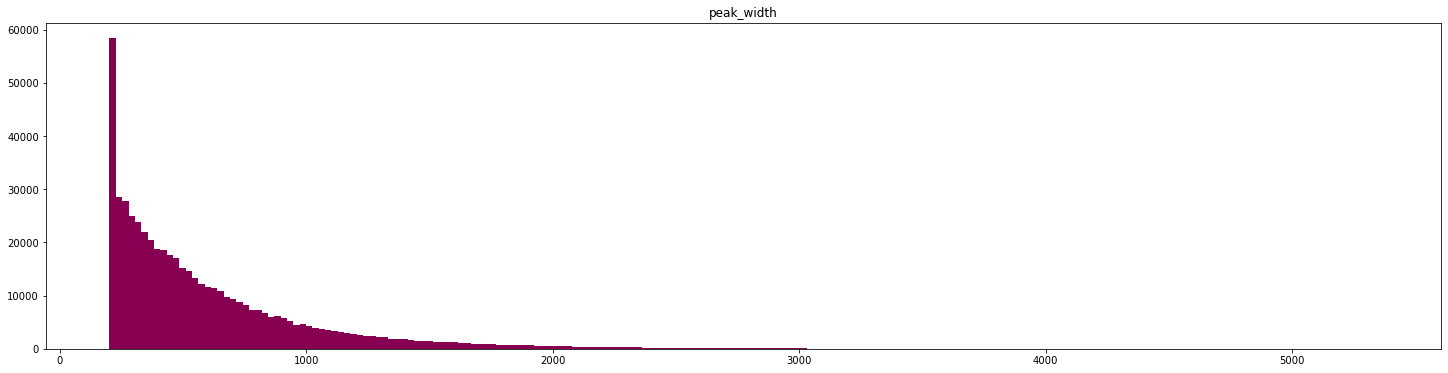

In [104]:
adata.var.hist(column = 'peak_width', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [105]:
var_qc = sc.pp.calculate_qc_metrics(adata, layer = "binary_raw")[1]
adata.var = pd.concat([adata.var, var_qc], 1)
adata

AnnData object with n_obs × n_vars = 91746 × 534188
    obs: 'code', 'sample', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [106]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:10026-10440,415,0,0,0,intergenic,NaN,NaN,58650,1,692,0.007543,0.007514,99.245744,692.0,6.541030
chr1:180682-181625,944,0,0,1,promoter,FO538757.2,ENSG00000279928,767,1,3970,0.043272,0.042362,95.672836,3970.0,8.286774
chr1:191218-191938,721,0,1,0,intron,FO538757.1,ENSG00000279457,3472,1,520,0.005668,0.005652,99.433218,520.0,6.255750
chr1:267866-268126,261,0,0,0,intergenic,NaN,NaN,67543,1,773,0.008425,0.008390,99.157456,773.0,6.651572
chr1:586067-586291,225,0,0,0,intergenic,NaN,NaN,100362,1,685,0.007466,0.007439,99.253373,685.0,6.530878


array([[<AxesSubplot:title={'center':'total_counts'}>]], dtype=object)

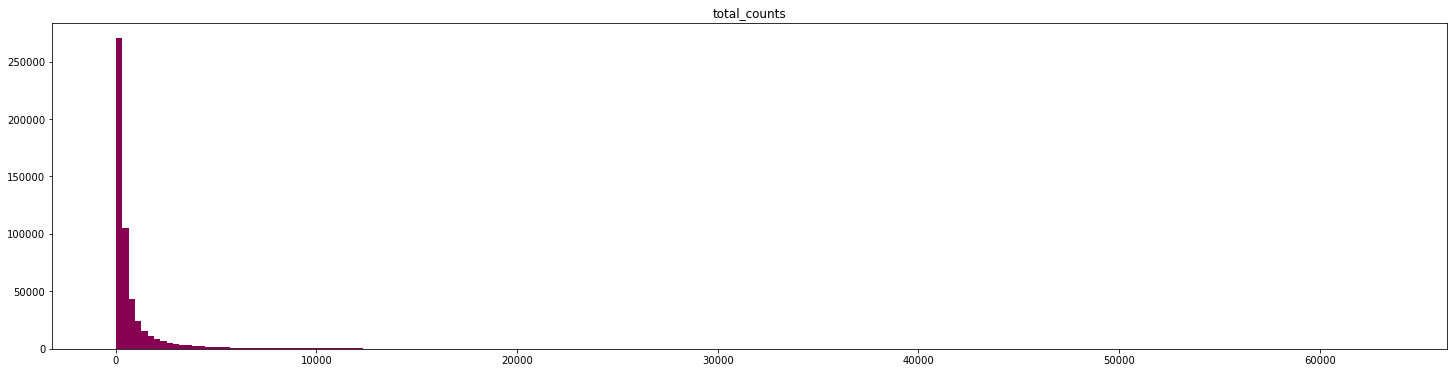

In [107]:
adata.var.hist(column = 'total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [108]:
thirty_percent = len(adata.obs_names) / 100 * 30
point_one_percent = len(adata.obs_names) / 100 * 0.1
print("30% : {}".format(thirty_percent))
print("0.1% : {}".format(point_one_percent))

30% : 27523.800000000003
0.1% : 91.74600000000001


In [109]:
# Accessible in at least k cells
adata = adata[:,adata.var.total_counts > point_one_percent]
adata = adata[:,adata.var.total_counts < thirty_percent]
adata

View of AnnData object with n_obs × n_vars = 91746 × 500566
    obs: 'code', 'sample', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [110]:
# Remove peaks in ENCODE blacklist
adata = adata[:, adata.var.ENCODE_blacklist == 0]
adata

View of AnnData object with n_obs × n_vars = 91746 × 498561
    obs: 'code', 'sample', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [111]:
# Filter by width (remove peaks at the lowest end, closest to min peak width in MACS2)

adata = adata[:, adata.var.peak_width > 210]
adata = adata[:, adata.var.peak_width < 1500]
adata

View of AnnData object with n_obs × n_vars = 91746 × 446862
    obs: 'code', 'sample', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [112]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:816774-817439,666,0,0,0,intergenic,NaN,NaN,106488,0,722,0.007870,0.007839,99.213045,722.0,6.583409
chr1:817726-818992,1267,0,0,0,intergenic,NaN,NaN,104935,0,1057,0.011521,0.011455,98.847906,1057.0,6.964136
chr1:825667-826063,397,0,0,0,intergenic,NaN,NaN,97864,0,657,0.007161,0.007136,99.283892,657.0,6.489205
chr1:826596-827807,1212,0,0,0,intergenic,NaN,NaN,96120,0,10499,0.114436,0.108348,88.556449,10499.0,9.259130
chr1:828735-829044,310,0,0,0,intergenic,NaN,NaN,94883,0,340,0.003706,0.003699,99.629412,340.0,5.831882


In [113]:
adata.var['annotation'].value_counts()

intergenic    201078
intron        185666
exon           46267
promoter       13851
Name: annotation, dtype: int64

In [114]:
adata.obs.head()

,code,sample,multiome_GermCells,multiome_Somatic
13-AAACAGCCAAGCGATG-1,13,FCA_GND10288176,NaN,granulosa
13-AAACAGCCACTAGCGT-1,13,FCA_GND10288176,NaN,preGC_IIb
13-AAACAGCCAGCCAGAA-1,13,FCA_GND10288176,oogonia_meiotic,NaN
13-AAACAGCCATCCAGGT-1,13,FCA_GND10288176,oogonia_STRA8,NaN
13-AAACATGCATCCCGCT-1,13,FCA_GND10288176,NaN,preGC_IIb


In [115]:
### Filter peaks that are not accessible in at least 5% of cells from a coarse cluster
min_frac=0.05
# Load cluster information from cellatac outputs
clusters = pd.read_table(input["clusters"], header = None, index_col = 0)
clusters.columns = ["cellatac_clusters"]
adata.obs = clusters.loc[adata.obs_names]
adata

AnnData object with n_obs × n_vars = 91746 × 446862
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [116]:
adata.obs.head()

,cellatac_clusters
13-AAACAGCCAAGCGATG-1,4
13-AAACAGCCACTAGCGT-1,3
13-AAACAGCCAGCCAGAA-1,3
13-AAACAGCCATCCAGGT-1,8
13-AAACATGCATCCCGCT-1,3


In [117]:
n_clusters = len(np.unique(adata.obs[["cellatac_clusters"]]))
clus_mat = np.empty([adata.n_obs, n_clusters])
for cl in np.unique(adata.obs[["cellatac_clusters"]]):
    clus_mat[np.where(adata.obs['cellatac_clusters']==cl)[0],cl] = 1

clus_mat = scipy.sparse.csr_matrix(clus_mat)
clus_mat[clus_mat != 1 ] = 0

/opt/conda/envs/atac_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3427: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [118]:
cl_peak_mat = np.dot(clus_mat.T, adata.layers["binary_raw"])

In [119]:
cl_peak_frac = cl_peak_mat/clus_mat.sum(0).T

In [120]:
cl_peak_frac.max(0).shape

(1, 446862)

In [121]:
bool_matrix = cl_peak_frac.max(0) > min_frac
bool_matrix.shape

(1, 446862)

In [122]:
bool_vector = np.squeeze(np.asarray(bool_matrix))
bool_vector.shape

(446862,)

In [123]:
adata = adata[:, bool_vector]

In [124]:
adata

View of AnnData object with n_obs × n_vars = 91746 × 153356
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [125]:
sc.pp.calculate_qc_metrics(adata, layer = "binary_raw", inplace = True)

Trying to set attribute `.obs` of view, copying.


array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

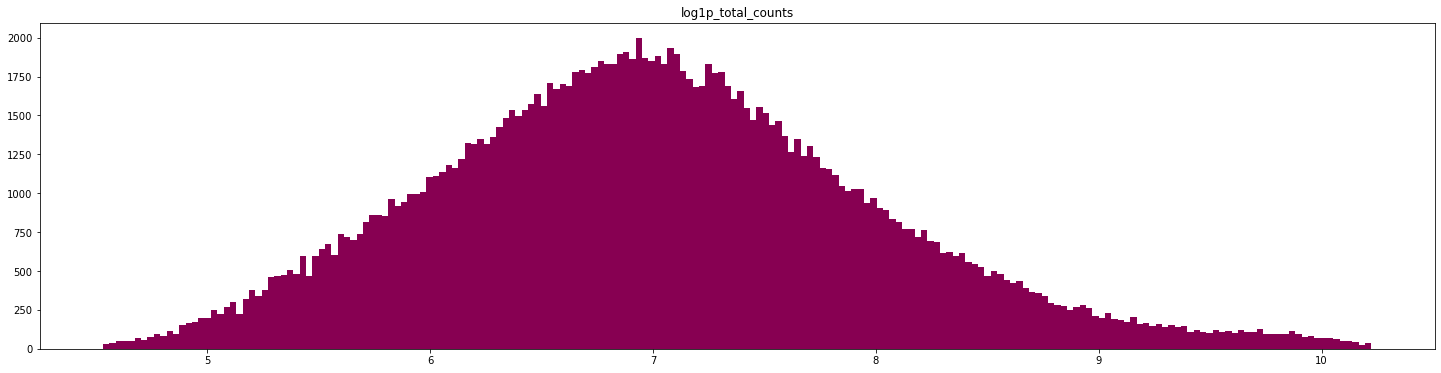

In [126]:
adata.var.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

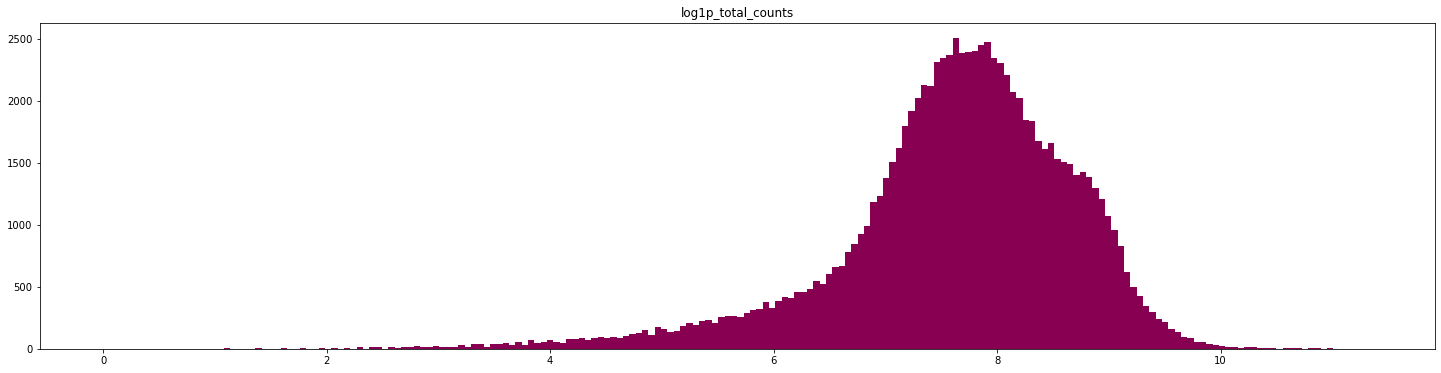

In [127]:
adata.obs.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [128]:
adata.obs['multiome_GermCells'] = adata.obs_names.map(pd.Series(germcells.celltype.values,index=germcells.ATAC_barcode).to_dict())
adata.obs['multiome_Somatic'] = adata.obs_names.map(pd.Series(supporting.celltype.values,index=supporting.ATAC_barcode).to_dict())

In [129]:
adata.obs.groupby('multiome_GermCells', as_index=False)['log1p_total_counts'].mean()

,multiome_GermCells,log1p_total_counts
0,Doublet,7.138975
1,PGC,6.888658
2,lowQC,6.137469
3,oocyte,7.134618
4,oogonia_STRA8,6.979627
5,oogonia_meiotic,7.515431
6,preOocyte,7.105744


In [130]:
adata.obs[adata.obs['multiome_GermCells'] == 'oocyte']['log1p_total_counts'].describe()

count    162.000000
mean       7.134618
std        1.470978
min        1.609438
25%        6.530874
50%        7.375849
75%        8.073781
max        9.868689
Name: log1p_total_counts, dtype: float64

In [131]:
adata.obs['multiome_GermCells'].value_counts()

oogonia_STRA8      2215
PGC                1483
oogonia_meiotic    1178
preOocyte           311
Doublet             252
oocyte              162
lowQC                92
Name: multiome_GermCells, dtype: int64

In [132]:
adata.obs.groupby('multiome_Somatic', as_index=False)['log1p_total_counts'].mean()

,multiome_Somatic,log1p_total_counts
0,CoelEpi_LHX9,6.997910
1,Doublet,7.511556
2,Mesenchymal_LHX9,6.765028
3,OSE,6.804958
4,OSE_cycling,7.452723
5,early_sPAX8,6.914789
6,early_supporting,7.170866
7,granulosa,6.233542
8,lowQC,6.359138
9,preGC_I,7.020728


In [137]:
bdata = adata[adata.obs.log1p_total_counts >= 4]
bdata

View of AnnData object with n_obs × n_vars = 90920 × 153356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [138]:
bdata.obs['multiome_Somatic'].value_counts()

preGC_IIa           3347
preGC_I             3236
preGC_IIb           2101
OSE                 1288
granulosa           1254
early_sPAX8         1160
early_supporting    1083
Mesenchymal_LHX9    1080
OSE_cycling          635
Doublet              452
lowQC                377
CoelEpi_LHX9         302
Name: multiome_Somatic, dtype: int64

In [139]:
bdata.obs['multiome_GermCells'].value_counts()

oogonia_STRA8      2135
PGC                1452
oogonia_meiotic    1142
preOocyte           299
Doublet             242
oocyte              158
lowQC                88
Name: multiome_GermCells, dtype: int64

In [140]:
bdata

View of AnnData object with n_obs × n_vars = 90920 × 153356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [141]:
## Write output anndata
bdata.write_h5ad(output["h5ad"])

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'multiome_GermCells' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'multiome_Somatic' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'annotation' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_name' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_id' as categorical


#### End of notebook